In [1]:
# =========================
# 1. Import Dependencies
# =========================
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ======================================
# 2. Load Training and Test Datasets
# ======================================

train_df = pd.read_csv("./data/training_data.csv")
test_df = pd.read_csv("./data/test_data.csv")

print("Training set size:", len(train_df))
print("Test set size:", len(test_df))

train_df.head()

Training set size: 856
Test set size: 294


,Molecule CAS,MorganFingerprint,Wavelength,Absorption Maxima
0,116453-73-7,0000000000000100000000000000000001100000000000...,763.0,1.00000
1,116453-73-7,0000000000000100000000000000000001100000000000...,328.0,0.40316
2,116453-73-7,0000000000000100000000000000000001100000000000...,696.0,0.27158
3,7235-40-7,0000100000000000000000000000000101001000000000...,451.0,1.00000
4,7235-40-7,0000100000000000000000000000000101001000000000...,267.0,0.22071


In [3]:
# ================================================================
# 3. Convert Morgan Fingerprint (Bitstring) to Numeric Array
# ================================================================

def bitstring_to_array(bitstring):
    return np.array([int(bit) for bit in bitstring])


# Convert train fingerprints
X_train = np.vstack(train_df["MorganFingerprint"].apply(bitstring_to_array).values)

# Convert test fingerprints
X_test = np.vstack(test_df["MorganFingerprint"].apply(bitstring_to_array).values)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Assume the target is Wavelength.
y_train = train_df["Wavelength"].values
y_test = test_df["Wavelength"].values

print("Sample of X_train[0]:", X_train[0][:50], "...")
print("Sample of y_train[0]:", y_train[0])

X_train shape: (856, 1024)
X_test shape: (294, 1024)
Sample of X_train[0]: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Sample of y_train[0]: 763.0


In [4]:
# =====================================
# 4. Train a Basic Random Forest Model
# =====================================

# Start with a default RandomForestRegressor to see how it performs.
basic_rf = RandomForestRegressor(random_state=42)
basic_rf.fit(X_train, y_train)

# Predictions
y_pred_basic = basic_rf.predict(X_test)

# Evaluate performance
mse_basic = mean_squared_error(y_test, y_pred_basic)
r2_basic = r2_score(y_test, y_pred_basic)

print("Basic RF Model Performance:")
print(f"  MSE: {mse_basic:.4f}")
print(f"  R^2: {r2_basic:.4f}")

Basic RF Model Performance:
  MSE: 15246.2294
  R^2: 0.3360


In [5]:
# =======================================
# 5. Hyperparameter Tuning via GridSearch
# =======================================

rf = RandomForestRegressor(random_state=42)

param_grid = {
    "n_estimators": [50, 100, 200],  # number of trees
    "max_depth": [None, 10, 20],  # max depth of each tree
    "max_features": ["sqrt", "log2"],  # number of features per split
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # we want to minimize MSE
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # use all CPUs
    verbose=2,
)

grid_search.fit(X_train, y_train)

print("\nBest hyperparameters found:")
print(grid_search.best_params_)

best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END .max_depth=None, max_features=sqrt, n_estimators=50; total time=   0.2s
[CV] END .max_depth=None, max_features=sqrt, n_estimators=50; total time=   0.3s
[CV] END .max_depth=None, max_features=sqrt, n_estimators=50; total time=   0.2s
[CV] END .max_depth=None, max_features=log2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.4s
[CV] END .max_depth=None, max_features=log2, n_estimators=50; total time=   0.3s
[CV] END .max_depth=None, max_features=log2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.5s
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=10, max_features=sqrt, n_e

In [6]:
# ===========================================
# 6. Evaluate the Best Model on Test Data
# ===========================================

y_pred_optimized = best_rf.predict(X_test)

mse_opt = mean_squared_error(y_test, y_pred_optimized)
r2_opt = r2_score(y_test, y_pred_optimized)

print("Optimized RF Model Performance:")
print(f"  MSE: {mse_opt:.4f}")
print(f"  R^2: {r2_opt:.4f}")

Optimized RF Model Performance:
  MSE: 16172.7057
  R^2: 0.2957


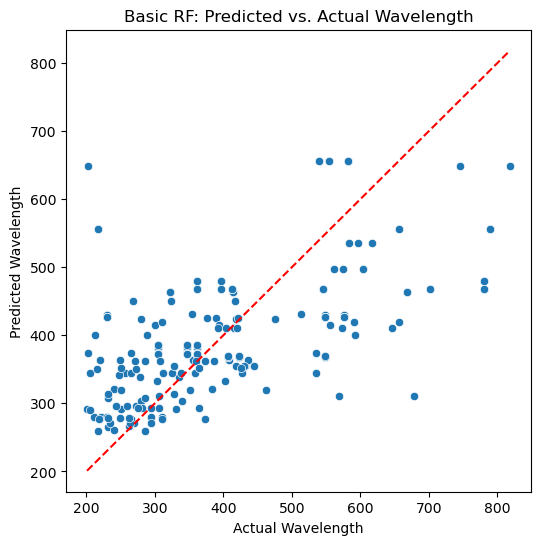

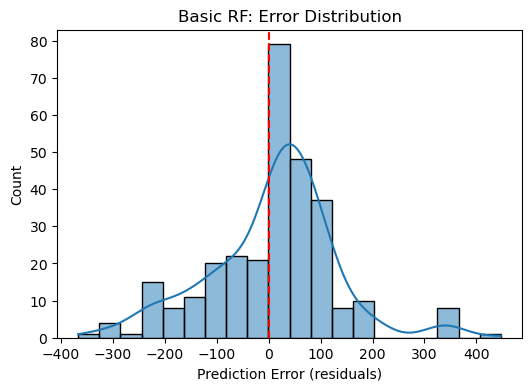

In [7]:
# =========================
# 7. Plot Results
# =========================

# 1. Predicted vs. Actual Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_basic)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red",
    linestyle="--",
)
plt.xlabel("Actual Wavelength")
plt.ylabel("Predicted Wavelength")
plt.title("Basic RF: Predicted vs. Actual Wavelength")
plt.show()

# 2. Error Distribution
errors = y_pred_basic - y_test  # residuals
plt.figure(figsize=(6, 4))
sns.histplot(errors, kde=True)
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Prediction Error (residuals)")
plt.ylabel("Count")
plt.title("Basic RF: Error Distribution")
plt.show()